- 6889747 Yi Zeng
- 6794870 Haodong Li

# 2. Experimentation with three different setups

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from transformers import BertTokenizerFast, BertModel
import datasets
from gensim.models import Word2Vec
import numpy as np
from seqeval.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

dataset = datasets.load_dataset('surrey-nlp/PLOD-CW-25')
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

dataset_ext = datasets.load_dataset('surrey-nlp/PLODv2-filtered')
train_data_ext = dataset_ext['train']
val_data_ext = dataset_ext['validation']
test_data_ext = dataset_ext['test']

## 2.1 Vary the text encoding
a. Data pre-processing technique: no preprocessing  
b. (varied) Text encoding/transformation into embeddings: word2vec, GloVe, pre-trained language model(BERT)  
c. Modelling Technique: LSTM with FC layer

Yi: word2vec+LSTM, GloVe+LSTM, merge and optimize code  
Haodong: BERT+LSTM

### - Initialization

In [3]:
%%time
#The original glove file(glove.6B.100d.txt) is 300mb, but we only need a portion of the words, search them and save them in NPZ format
#So it only needs to be executed once
def convert_glove_to_npz(glove_path, output_npz_path):
    word_counts = Counter()
    for sentence in train_data:
        word_counts.update(sentence['tokens'])
    for sentence in train_data_ext:
        word_counts.update(sentence['tokens'])
    vocab_all = ['<PAD>', '<UNK>'] + [word for word, count in sorted(word_counts.items(), key = lambda x:-x[1])]#sort by frequency
    word2id_all = {word: idx for idx, word in enumerate(vocab_all)}

    words = {}
    vectors = np.zeros((len(vocab_all), 100), dtype=np.float32)
    count = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for idx, line in tqdm(enumerate(f), total=400000, desc="Processing"):#This file has a total of 40000 lines
            row = line.rstrip().split()
            if row[0] in vocab_all:
                count += 1
                words[row[0]] = word2id_all[row[0]]
                vectors[word2id_all[row[0]]] = np.array(row[1:], dtype=np.float32)

    np.savez_compressed(
        output_npz_path,
        words=words,
        vectors=vectors
    )
    print(f"Saved compressed GloVe to {output_npz_path}, found {count}/{len(vocab_all)} words")

#convert_glove_to_npz("glove.6B.100d.txt", "glove.6B.100d.PLOD-CW-25.npz")

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
#Init
class Config:
    GLOVE_NPZ_PATH = 'glove.6B.100d.PLOD-CW-25.npz'
    EMBEDDING_VEC = 100
    HIDDEN = 128
    BATCH_SIZE = 32
    EPOCHS = 10
    BERT_MODEL_NAME = 'bert-base-cased'
    NUM_LSTM_LAYERS = 2
    NUM_RNN_LAYERS = 2
    MAX_LENGTH = 128
    '''
    Yi:An interesting situation is that when the learning rate is 0.00001, word2vec and glove will experience local optima,
    resulting in an F1 score of 0, but not when the learning rate is 0.001.
    However, when the learning rate is equal to 0.001, the convergence speed of BERT is insufficient,
    resulting in a low F1 score
    '''
    BERT_LEARNING_RATE = 1e-5
    LEARNING_RATE = 0.001# for word2vec, GloVe
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
#Build vocabulary, convert to ID
def build_vocab_id(data):
    word_counts = Counter()
    for sentence in data:
        word_counts.update(sentence['tokens'])
    vocab = ['<PAD>', '<UNK>'] + [word for word, count in sorted(word_counts.items(), key = lambda x:-x[1])]#sort by frequency
    word2id = {word: idx for idx, word in enumerate(vocab)}
    return vocab, word2id

vocab, word2id = build_vocab_id(train_data)

#Convert ner_tags to ID
ner_labels = set()
for split in [train_data, val_data, test_data]:
    for data in split:
        ner_labels.update(data['ner_tags'])
ner_tag2id = {tag: idx for idx, tag in enumerate(ner_labels)}
id2ner = {value: key for key, value in ner_tag2id.items()}

In [9]:
#Word2Vec
def build_w2v_matrix(word2id, w2v_model):
    embedding_w2v_matrix = np.zeros((len(vocab), Config.EMBEDDING_VEC))
    for word, idx in word2id.items():
        if word in w2v_model.wv:
            embedding_w2v_matrix[idx] = w2v_model.wv[word]
        elif word == '<PAD>':
            embedding_w2v_matrix[idx] = np.zeros(Config.EMBEDDING_VEC)
        else:
            embedding_w2v_matrix[idx] = np.random.normal(size=(Config.EMBEDDING_VEC,))
    return embedding_w2v_matrix

w2v_model = Word2Vec(train_data['tokens'], vector_size=Config.EMBEDDING_VEC, window=3, min_count=1, workers=4, epochs=50)
embedding_w2v_matrix = build_w2v_matrix(word2id, w2v_model)

In [11]:
#GloVe
def load_compressed_glove(npz_path):
    data = np.load(npz_path, mmap_mode='r', allow_pickle=True)
    return data['words'], data['vectors']

glove_words, glove_vectors = load_compressed_glove(Config.GLOVE_NPZ_PATH)

def build_glove_matrix(word2id, glove_words, glove_vectors):
    embedding_glove_matrix = np.zeros((len(word2id), Config.EMBEDDING_VEC))
    for word, idx in word2id.items():
        if word in glove_words:
            embedding_glove_matrix[idx] = glove_vectors[glove_words['word']]
        elif word == '<PAD>':
            embedding_glove_matrix[idx] = np.zeros(Config.EMBEDDING_VEC)
        else:
            embedding_glove_matrix[idx] = np.random.normal(size=(Config.EMBEDDING_VEC,))
    return embedding_glove_matrix

embedding_glove_matrix = build_glove_matrix(word2id, glove_words, glove_vectors)

In [13]:
#pre-trained language model: BERT
tokenizer = BertTokenizerFast.from_pretrained(Config.BERT_MODEL_NAME)

In [15]:
#Init custom dataset
class NER_Dataset(Dataset):
    def __init__(self, data, embedding_type = None, tokenizer = None):
        self.data = data
        self.embedding_type = embedding_type
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sentence = self.data[idx]
        tokens = sentence['tokens']
        ner_tags = sentence['ner_tags']

        if self.embedding_type == 'BERT':#BERT
            encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=Config.MAX_LENGTH,
            padding=False
            )

            word_ids = encoding.word_ids()
            labels = []
            current_word_id = None
            
            for word_id in word_ids:
                if word_id is None:
                    labels.append(-100)
                else:
                    if word_id != current_word_id:
                        labels.append(ner_tag2id[ner_tags[word_id]])
                        current_word_id = word_id
                    else:
                        labels.append(-100)
    
            return {
                'input_ids': encoding['input_ids'],
                'attention_mask': encoding['attention_mask'],
                'labels': labels
            }
        else:
            token_ids = [word2id.get(token, word2id['<UNK>']) for token in tokens]
            ner_ids = [ner_tag2id[tag] for tag in ner_tags]
            
            return {
                'token_ids': torch.LongTensor(token_ids),
                'ner_ids': torch.LongTensor(ner_ids),
                'lengths': len(token_ids)
            }

#Init custom collate fuction
def collate_fn(batch):
    if 'attention_mask' in batch[0]:#BERT
        max_length = max(len(x['input_ids']) for x in batch)
    
        input_ids = []
        attention_masks = []
        labels = []
        
        for x in batch:
            pad_length = max_length - len(x['input_ids'])
            input_ids.append(x['input_ids'] + [tokenizer.pad_token_id] * pad_length)
            attention_masks.append(x['attention_mask'] + [0] * pad_length)
            labels.append(x['labels'] + [-100] * pad_length)
        
        return {
            'input_ids': torch.LongTensor(input_ids).to(Config.DEVICE),
            'attention_mask': torch.LongTensor(attention_masks).to(Config.DEVICE),
            'labels': torch.LongTensor(labels).to(Config.DEVICE)
        }
    else:
        token_ids = [x['token_ids'] for x in batch]
        ner_ids = [x['ner_ids'] for x in batch]
        lengths = [x['lengths'] for x in batch]
        
        sorted_indices = np.argsort(lengths)[::-1]
        token_ids = [token_ids[i] for i in sorted_indices]
        ner_ids = [ner_ids[i] for i in sorted_indices]
        lengths = [lengths[i] for i in sorted_indices]
    
        #Fill to the same length
        token_ids = pad_sequence(token_ids, batch_first=True, padding_value=word2id['<PAD>'])
        ner_ids = pad_sequence(ner_ids, batch_first=True, padding_value=-100)
        
        return {
            'token_ids': token_ids.to(Config.DEVICE),
            'ner_ids': ner_ids.to(Config.DEVICE),
            'lengths': torch.LongTensor(lengths).to(Config.DEVICE)
        }

In [17]:
#Word2Vec&GloVe
train_dataset = NER_Dataset(train_data)
val_dataset = NER_Dataset(val_data)
test_dataset = NER_Dataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)

#BERT
train_dataset_bert = NER_Dataset(train_data, 'BERT', tokenizer)
val_dataset_bert = NER_Dataset(val_data, 'BERT', tokenizer)
test_dataset_bert = NER_Dataset(test_data, 'BERT', tokenizer)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)

### - Initial model

In [19]:
#Init model
class NER_Model(nn.Module):
    def __init__(self, embedding_type, model_type='LSTM'):
        super().__init__()
        self.embedding_type = embedding_type
        self.model_type = model_type

        if self.embedding_type == 'Word2Vec':
            self.embedding = nn.Embedding.from_pretrained(
                torch.FloatTensor(embedding_w2v_matrix),
                padding_idx=word2id['<PAD>']
            )
            self.lstm = nn.LSTM(Config.EMBEDDING_VEC, Config.HIDDEN, bidirectional=True, num_layers=Config.NUM_LSTM_LAYERS, dropout=0.3)
        elif self.embedding_type == 'GloVe':
            self.embedding = nn.Embedding.from_pretrained(
                torch.FloatTensor(embedding_glove_matrix),
                padding_idx=word2id['<PAD>']
            )
            self.lstm = nn.LSTM(Config.EMBEDDING_VEC, Config.HIDDEN, bidirectional=True, num_layers=Config.NUM_LSTM_LAYERS, dropout=0.3)
        elif self.embedding_type == 'BERT':
            self.bertmodel = BertModel.from_pretrained(Config.BERT_MODEL_NAME)
            self.lstm = nn.LSTM(
            input_size=self.bertmodel.config.hidden_size,
            hidden_size=Config.HIDDEN,
            num_layers=Config.NUM_LSTM_LAYERS,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
            )
            self.rnn = nn.RNN(
            input_size=self.bertmodel.config.hidden_size,
            hidden_size=Config.HIDDEN,
            num_layers=Config.NUM_RNN_LAYERS,
            bidirectional=True,
            batch_first=True,
            nonlinearity='relu',
            dropout=0.3
            )
        self.fc = nn.Linear(Config.HIDDEN*2, len(ner_tag2id))
        
    def forward(self, token_ids=None, lengths=None, input_ids=None, attention_mask=None):
        if self.embedding_type == 'BERT':
            outputs = self.bertmodel(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = outputs.last_hidden_state
            if self.model_type == 'LSTM':
                output, _ = self.lstm(sequence_output)
            else:
                output, _ = self.rnn(sequence_output)
            return self.fc(output)
        else:
            embedding_tokens = self.embedding(token_ids)
            packed = pack_padded_sequence(embedding_tokens, lengths.cpu(), batch_first=True, enforce_sorted=False)
            output, _ = self.lstm(packed)
            output, _ = pad_packed_sequence(output, batch_first=True)
            return self.fc(output)

In [21]:
#Init evaluation metrics
def eval_ner(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    precision = report['micro avg']['precision']
    recall = report['micro avg']['recall']
    f1 = report['micro avg']['f1-score']

    return precision, recall, f1, report

In [23]:
#Init training
def training(model, model_name, embedding_type, train_loader, val_loader):
    best_f1 = -1
    train_loss_list = []
    val_loss_list = []
    val_f1_list = []
    for epoch in range(Config.EPOCHS):
        #Train
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            if embedding_type == 'BERT':#BERT
                logits = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                loss = CEL(logits.view(-1, len(ner_tag2id)), batch['labels'].view(-1))
            else:
                logits = model(token_ids=batch['token_ids'], lengths=batch['lengths'])
                loss = CEL(logits.view(-1, len(ner_tag2id)), batch['ner_ids'].view(-1))         
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        #Evaluate
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
                if embedding_type == 'BERT':#BERT
                    logits = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                    loss = CEL(logits.view(-1, len(ner_tag2id)), batch['labels'].view(-1))
                    val_loss += loss.item()
                    
                    preds = torch.argmax(logits, dim=-1).cpu().numpy()
                    labels = batch['labels'].cpu().numpy()

                    for i in range(preds.shape[0]):
                        val_labels = []
                        val_preds = []
                        for j in range(preds.shape[1]):
                            if labels[i][j] != -100:
                                val_labels.append(id2ner[labels[i][j]])
                                val_preds.append(id2ner[preds[i][j]])
                        all_labels.append(val_labels)
                        all_preds.append(val_preds)
                else:
                    logits = model(token_ids=batch['token_ids'], lengths=batch['lengths'])
                    loss = CEL(logits.view(-1, len(ner_tag2id)), batch['ner_ids'].view(-1)) 
                    val_loss += loss.item()
                    
                    preds = torch.argmax(logits, dim=-1).cpu().numpy()
                    labels = batch['ner_ids'].cpu().numpy()

                    for i in range(len(batch['lengths'])):
                        val_preds = []
                        val_labels = []
                        length = batch['lengths'][i]
                        result_preds = preds[i, :length]
                        result_labels = labels[i, :length]
                        mask = result_labels != -100
                        for i in result_preds[mask].tolist():
                            val_preds.append(id2ner[i])
                        for i in result_labels[mask].tolist():
                            val_labels.append(id2ner[i])
                        all_preds.append(val_preds)
                        all_labels.append(val_labels)

        _, _, val_f1, _ = eval_ner(all_labels, all_preds)
        train_loss_list.append(train_loss/len(train_loader))
        val_loss_list.append(val_loss/len(val_loader))
        val_f1_list.append(val_f1)
    
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), model_name)
            print('Best model saved!')
        
        print(f"Epoch {epoch+1}/{Config.EPOCHS}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val F1: {val_f1:.4f}\n")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, 'b', label='Training Loss', marker='o')
    plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, 'r', label='Validation Loss', marker='o')
    plt.plot(range(1, len(val_f1_list) + 1), val_f1_list, 'g', label='F1 Score', marker='o')
    plt.title('Training & Validation Loss & F1 Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss & Score')
    plt.legend()
    plt.grid(True)
    plt.show()

### - Training

#### - BERT+LSTM

BERT+LSTM type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.18it/s]


Best model saved!
Epoch 1/10
Train Loss: 1.0344
Val Loss: 0.9215
Val F1: 0.0000



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.61it/s]


Best model saved!
Epoch 2/10
Train Loss: 0.8595
Val Loss: 0.8009
Val F1: 0.0467



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.05it/s]


Best model saved!
Epoch 3/10
Train Loss: 0.7291
Val Loss: 0.6988
Val F1: 0.1051



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.42it/s]


Best model saved!
Epoch 4/10
Train Loss: 0.6496
Val Loss: 0.6516
Val F1: 0.2303



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


Best model saved!
Epoch 5/10
Train Loss: 0.6043
Val Loss: 0.6238
Val F1: 0.5167



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


Best model saved!
Epoch 6/10
Train Loss: 0.5687
Val Loss: 0.6003
Val F1: 0.6435



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


Best model saved!
Epoch 7/10
Train Loss: 0.5367
Val Loss: 0.5833
Val F1: 0.7314



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


Best model saved!
Epoch 8/10
Train Loss: 0.5133
Val Loss: 0.5735
Val F1: 0.7803



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


Best model saved!
Epoch 9/10
Train Loss: 0.4926
Val Loss: 0.5594
Val F1: 0.7881



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


Best model saved!
Epoch 10/10
Train Loss: 0.4751
Val Loss: 0.5565
Val F1: 0.7886



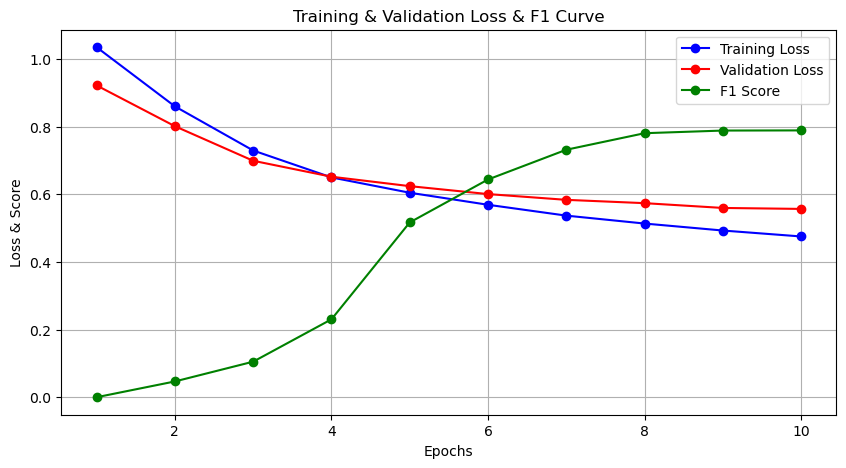

CPU times: total: 3min 40s
Wall time: 4min 33s


In [25]:
%%time
#BERT+LSTM
print('BERT+LSTM type training...')
model_bert_lstm = NER_Model('BERT','LSTM').to(Config.DEVICE)
optimizer = optim.Adam(model_bert_lstm.parameters(), lr=Config.BERT_LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_bert_lstm,'best_bert_LSTM.pth', 'BERT', train_loader_bert, val_loader_bert)

#### - Word2Vec+LSTM

Word2Vec+LSTM type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.19it/s]


Best model saved!
Epoch 1/10
Train Loss: 0.8128
Val Loss: 0.6687
Val F1: 0.5339



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.33it/s]


Best model saved!
Epoch 2/10
Train Loss: 0.6141
Val Loss: 0.6080
Val F1: 0.6362



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.20it/s]


Epoch 3/10
Train Loss: 0.5755
Val Loss: 0.5960
Val F1: 0.6324



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.77it/s]


Best model saved!
Epoch 4/10
Train Loss: 0.5627
Val Loss: 0.5859
Val F1: 0.6735



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.69it/s]


Best model saved!
Epoch 5/10
Train Loss: 0.5483
Val Loss: 0.5843
Val F1: 0.6825



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.75it/s]


Epoch 6/10
Train Loss: 0.5424
Val Loss: 0.5880
Val F1: 0.6821



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.60it/s]


Epoch 7/10
Train Loss: 0.5313
Val Loss: 0.5886
Val F1: 0.6772



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


Epoch 8/10
Train Loss: 0.5228
Val Loss: 0.5841
Val F1: 0.6761



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.29it/s]


Epoch 9/10
Train Loss: 0.5147
Val Loss: 0.5839
Val F1: 0.6735



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.06it/s]


Epoch 10/10
Train Loss: 0.5085
Val Loss: 0.5884
Val F1: 0.6701



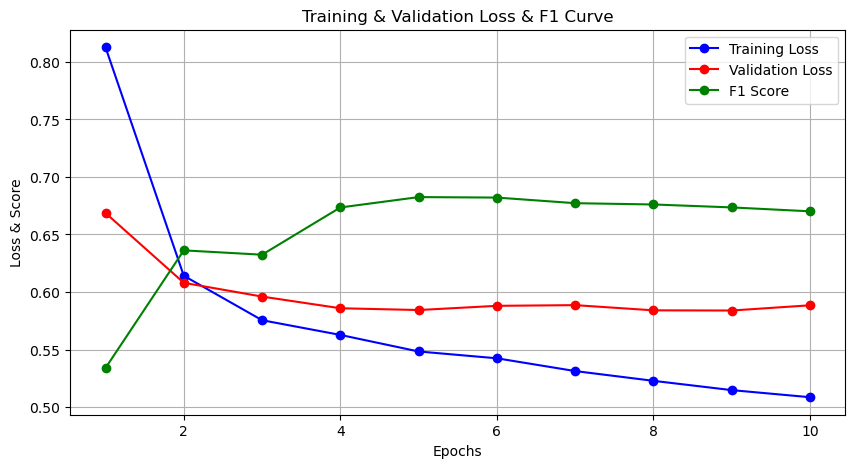

CPU times: total: 1min 3s
Wall time: 1min 1s


In [27]:
%%time
#Word2Vec
print('Word2Vec+LSTM type training...')
model_w2v = NER_Model('Word2Vec').to(Config.DEVICE)
optimizer = optim.Adam(model_w2v.parameters(), lr=Config.LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_w2v,'best_w2v_LSTM.pth', 'Word2Vec', train_loader, val_loader)

#### - GloVe+LSTM

GloVe+LSTM type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.69it/s]


Best model saved!
Epoch 1/10
Train Loss: 0.8873
Val Loss: 0.7388
Val F1: 0.2343



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.99it/s]


Best model saved!
Epoch 2/10
Train Loss: 0.6670
Val Loss: 0.6541
Val F1: 0.5683



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.83it/s]


Best model saved!
Epoch 3/10
Train Loss: 0.6075
Val Loss: 0.6606
Val F1: 0.6150



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.51it/s]


Best model saved!
Epoch 4/10
Train Loss: 0.5796
Val Loss: 0.6262
Val F1: 0.6418



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.22it/s]


Epoch 5/10
Train Loss: 0.5498
Val Loss: 0.6214
Val F1: 0.6323



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.00it/s]


Epoch 6/10
Train Loss: 0.5239
Val Loss: 0.6250
Val F1: 0.6276



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.65it/s]


Epoch 7/10
Train Loss: 0.5032
Val Loss: 0.6415
Val F1: 0.6359



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.11it/s]


Best model saved!
Epoch 8/10
Train Loss: 0.4808
Val Loss: 0.6372
Val F1: 0.6503



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.68it/s]


Epoch 9/10
Train Loss: 0.4628
Val Loss: 0.6652
Val F1: 0.6184



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.71it/s]


Best model saved!
Epoch 10/10
Train Loss: 0.4581
Val Loss: 0.6601
Val F1: 0.6531



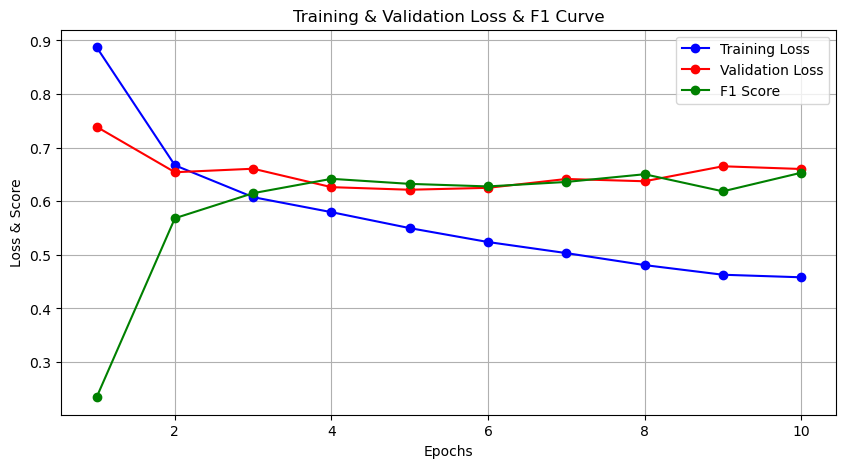

CPU times: total: 1min 2s
Wall time: 1min 1s


In [29]:
%%time
#GloVe
print('GloVe+LSTM type training...')
model_glove = NER_Model('GloVe').to(Config.DEVICE)
optimizer = optim.Adam(model_glove.parameters(), lr=Config.LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_glove, 'best_glove_LSTM.pth', 'GloVe', train_loader, val_loader)

## 2.2 vary the neural layer  
a. Data pre-processing technique: no preprocessing  
b. Text encoding/transformation into embeddings: pre-trained language model(BERT)  
c. (varied) Modelling Technique: RNN with FC layer, LSTM with FC layer (from 2.1), Transformer (included in experiment3.ipynb)

Haodong: BERT+RNN  
Yi: merge and optimize code

#### - BERT+LSTM
Please see the result from 2.1

#### - BERT+RNN

BERT+RNN type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.62it/s]


Best model saved!
Epoch 1/10
Train Loss: 0.8663
Val Loss: 0.6043
Val F1: 0.6340



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.44it/s]


Best model saved!
Epoch 2/10
Train Loss: 0.5434
Val Loss: 0.5409
Val F1: 0.7773



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.40it/s]


Best model saved!
Epoch 3/10
Train Loss: 0.4969
Val Loss: 0.5467
Val F1: 0.7972



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.18it/s]


Epoch 4/10
Train Loss: 0.4783
Val Loss: 0.5310
Val F1: 0.7957



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


Best model saved!
Epoch 5/10
Train Loss: 0.4645
Val Loss: 0.5480
Val F1: 0.8037



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


Best model saved!
Epoch 6/10
Train Loss: 0.4543
Val Loss: 0.5537
Val F1: 0.8063



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


Best model saved!
Epoch 7/10
Train Loss: 0.4439
Val Loss: 0.5467
Val F1: 0.8102



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


Epoch 8/10
Train Loss: 0.4349
Val Loss: 0.5430
Val F1: 0.8080



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch 9/10
Train Loss: 0.4255
Val Loss: 0.5455
Val F1: 0.8009



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch 10/10
Train Loss: 0.4202
Val Loss: 0.5548
Val F1: 0.8016



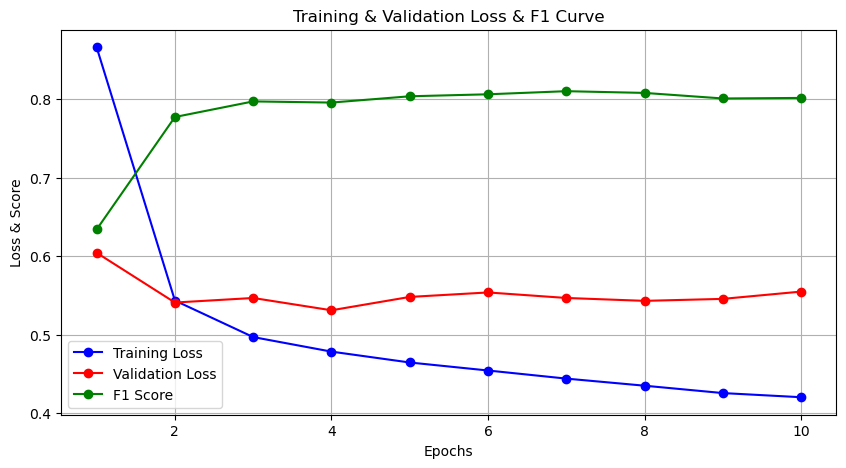

CPU times: total: 3min 34s
Wall time: 4min 9s


In [31]:
%%time
#BERT+RNN
print('BERT+RNN type training...')
model_bert_rnn = NER_Model('BERT','RNN').to(Config.DEVICE)
optimizer = optim.Adam(model_bert_rnn.parameters(), lr=Config.BERT_LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_bert_rnn,'best_bert_RNN.pth', 'BERT', train_loader_bert, val_loader_bert)

#### - BERT+Transformer
Please see experiment3.ipynb

# 3. Analyse testing for each of the three experiment setup variations

Yi: Coding  
Haodong: Check and analysis

In [52]:
import pandas as pd

def expand_seq(tags):
    result = []
    for seq in tags:
        for label in seq:
            result.append(label)
    return result

def testing(model, model_name, embedding_type, test_loader):
    model.load_state_dict(torch.load(model_name))
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            if embedding_type == 'BERT':#BERT
                logits = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                labels = batch['labels'].cpu().numpy()

                for i in range(preds.shape[0]):
                    val_labels = []
                    val_preds = []
                    for j in range(preds.shape[1]):
                        if labels[i][j] != -100:
                            val_labels.append(id2ner[labels[i][j]])
                            val_preds.append(id2ner[preds[i][j]])
                    all_labels.append(val_labels)
                    all_preds.append(val_preds)
            else:
                logits = model(token_ids=batch['token_ids'], lengths=batch['lengths'])
                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                labels = batch['ner_ids'].cpu().numpy()

                for i in range(len(batch['lengths'])):
                    val_preds = []
                    val_labels = []
                    length = batch['lengths'][i]
                    result_preds = preds[i, :length]
                    result_labels = labels[i, :length]
                    mask = result_labels != -100
                    for i in result_preds[mask].tolist():
                        val_preds.append(id2ner[i])
                    for i in result_labels[mask].tolist():
                        val_labels.append(id2ner[i])
                    all_preds.append(val_preds)
                    all_labels.append(val_labels)

    precision, recall, f1, report = eval_ner(all_labels, all_preds)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    labels = [value for key,value in enumerate(ner_tag2id)]
    label_true = expand_seq(all_labels)
    label_pred = expand_seq(all_preds)
    matrix = confusion_matrix(label_true, label_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return {'Precision': precision, 'Recall': recall, 'F1': f1}

## 3.1

Word2Vec type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.27it/s]


Precision: 0.7314
Recall: 0.6919
F1: 0.7111


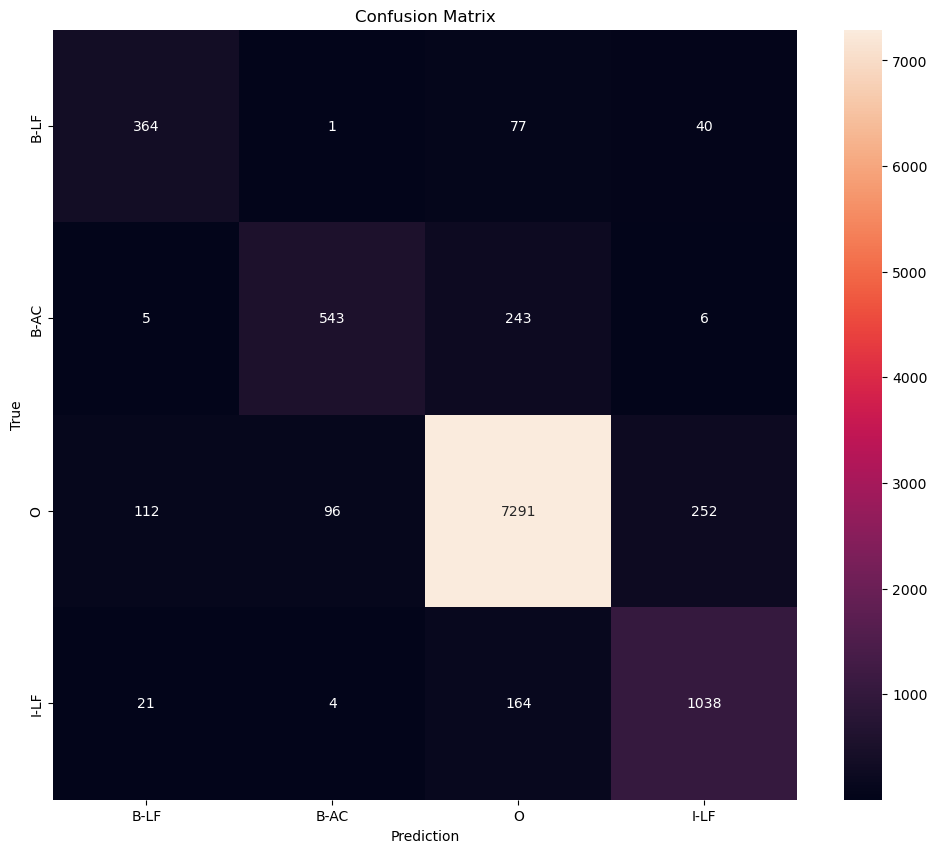

GloVe type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 22.06it/s]


Precision: 0.7251
Recall: 0.6372
F1: 0.6783


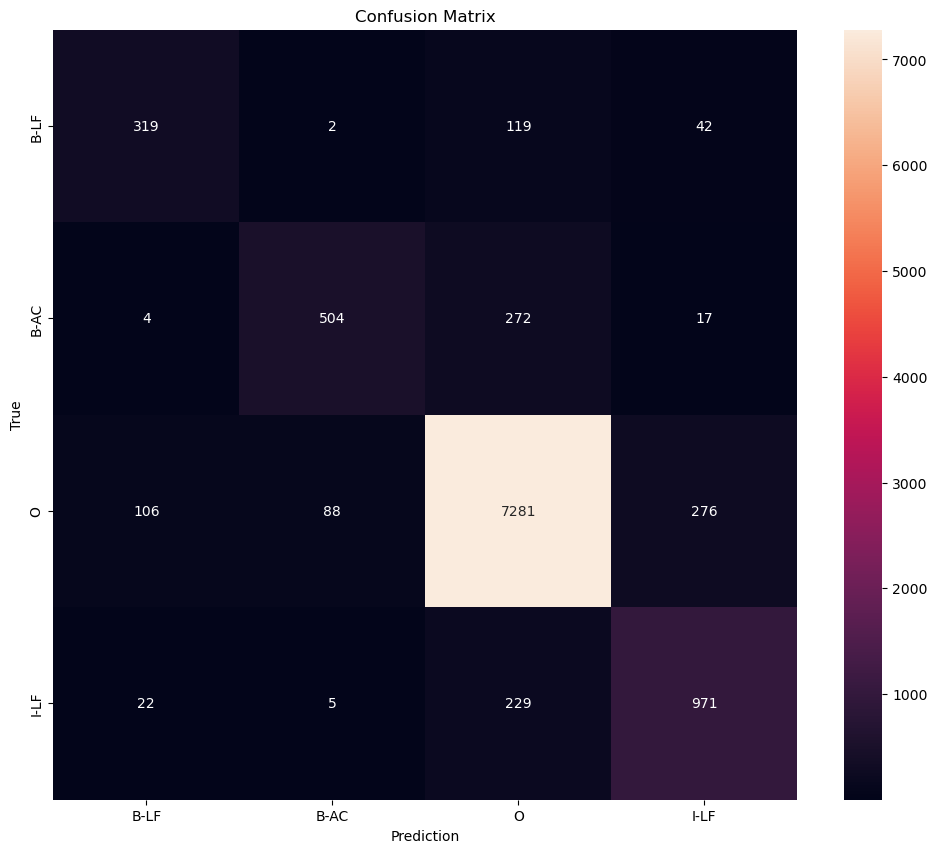

BERT+LSTM type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.19it/s]


Precision: 0.7635
Recall: 0.8979
F1: 0.8253


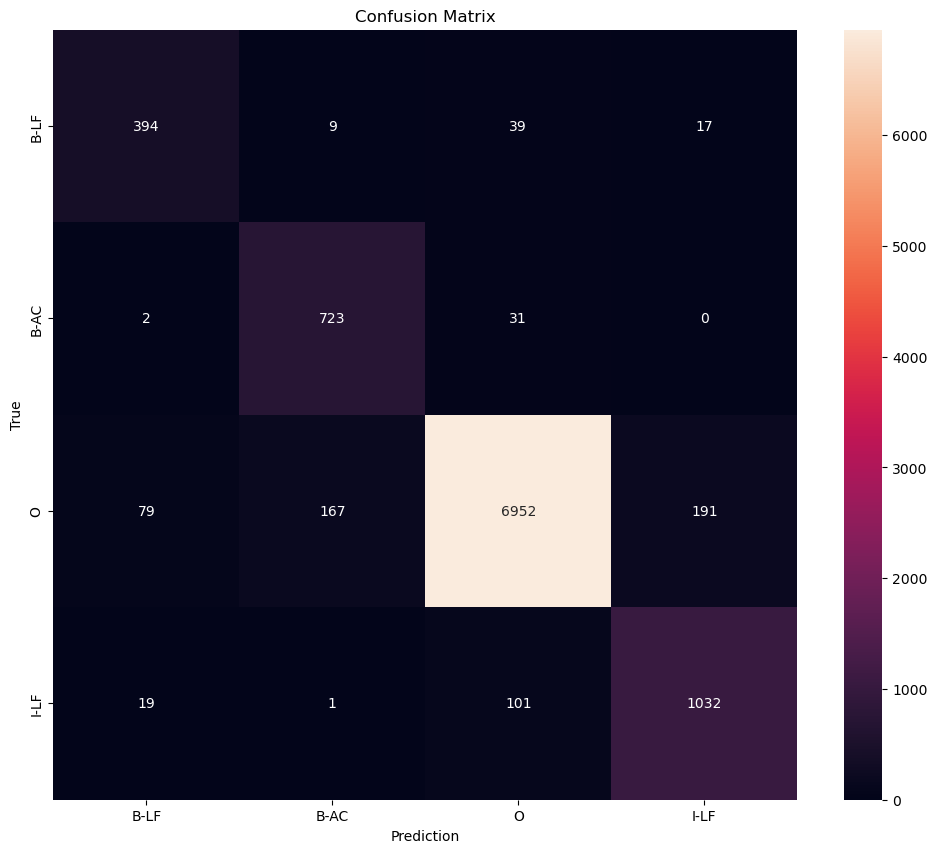

               Precision    Recall        F1
Word2Vec+LSTM   0.731405  0.691947  0.711129
GloVe+LSTM      0.725089  0.637217  0.678319
BERT+LSTM       0.763471  0.897942  0.825265


In [54]:
metrics_result = {}

print('Word2Vec type testing...')
model_w2v = NER_Model('Word2Vec').to(Config.DEVICE)
optimizer = optim.Adam(model_w2v.parameters(), lr=Config.LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
metrics_result['Word2Vec+LSTM'] = testing(model_w2v,'best_w2v_LSTM.pth', 'Word2Vec', test_loader)

print('GloVe type testing...')
model_glove = NER_Model('GloVe').to(Config.DEVICE)
optimizer = optim.Adam(model_glove.parameters(), lr=Config.LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
metrics_result['GloVe+LSTM'] = testing(model_glove,'best_glove_LSTM.pth', 'GloVe', test_loader)

print('BERT+LSTM type testing...')
model_bert_lstm = NER_Model('BERT','LSTM').to(Config.DEVICE)
optimizer = optim.Adam(model_bert_lstm.parameters(), lr=Config.BERT_LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
metrics_result['BERT+LSTM'] = testing(model_bert_lstm,'best_bert_LSTM.pth', 'BERT', test_loader_bert)

print(pd.DataFrame(metrics_result).T)

## 3.2

BERT+LSTM type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 10.29it/s]


Precision: 0.7635
Recall: 0.8979
F1: 0.8253


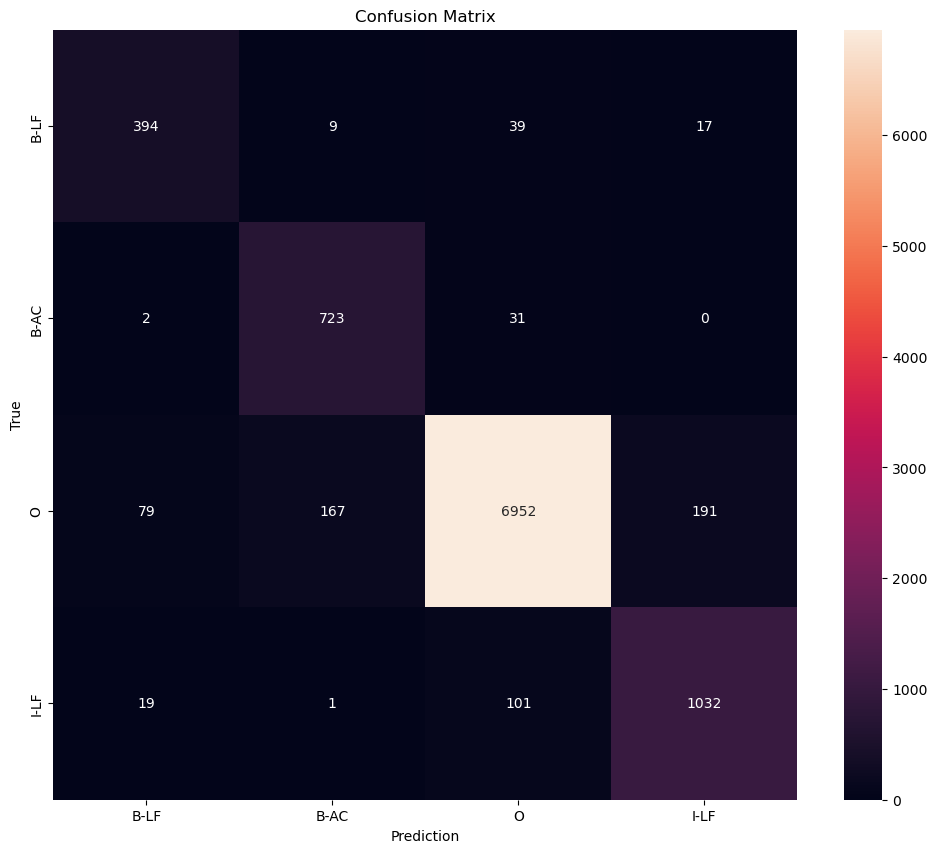

BERT+RNN type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.83it/s]


Precision: 0.7891
Recall: 0.9210
F1: 0.8500


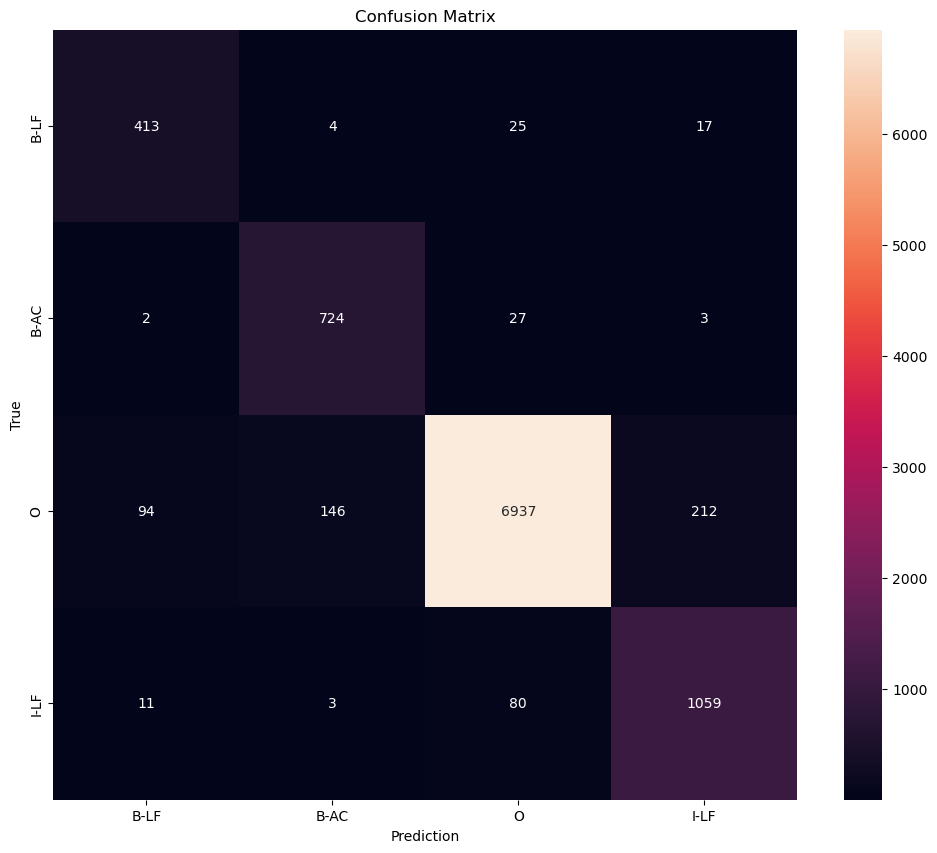

           Precision    Recall        F1
BERT+LSTM   0.763471  0.897942  0.825265
BERT+RNN    0.789140  0.920988  0.849981


In [56]:
metrics_result = {}

print('BERT+LSTM type testing...')
model_bert_lstm = NER_Model('BERT','LSTM').to(Config.DEVICE)
optimizer = optim.Adam(model_bert_lstm.parameters(), lr=Config.BERT_LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
metrics_result['BERT+LSTM'] = testing(model_bert_lstm,'best_bert_LSTM.pth', 'BERT', test_loader_bert)

print('BERT+RNN type testing...')
model_bert_rnn = NER_Model('BERT','RNN').to(Config.DEVICE)
optimizer = optim.Adam(model_bert_rnn.parameters(), lr=Config.BERT_LEARNING_RATE)
CEL = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
metrics_result['BERT+RNN'] = testing(model_bert_rnn,'best_bert_RNN.pth', 'BERT', test_loader_bert)

print(pd.DataFrame(metrics_result).T)

BERT+Transformer please see experiment3.ipynb

## 3.3

Please see experiment3.ipynb